In [7]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [8]:
gene = "RPS24"

In [9]:
outpath = "/scratch/PI/horence/JuliaO/single_cell/Differential_Splicing/notebooks/output/RPS24_scatter_2/"

In [10]:
# def compartment_colors(compartments):

#     import matplotlib.colors as pltcolors

#     cmap = plt.cm.get_cmap("YlOrRd")

#     compartment_color_dict = {}
#     j=1/len(compartments)
#     for c in compartments:
#         compartment_color_dict[c] = pltcolors.to_hex(cmap(j))
#         j+=1/len(compartments)

#     return compartment_color_dict
  
def compartment_colors(compartments):
  compartment_color_dict = {comp : col for comp, col in zip(compartments,sns.color_palette("deep",len(compartments)))}
  return compartment_color_dict

In [11]:
# datanames = ["TS_10x_redo","TSP2_10x_rerun_3prime_RPS24"]
datanames = ["HLCA4_P2_10x_with_postprocessing_lung","HLCA4_P3_10x_with_postprocessing_lung"]
# datanames = ["HLCA4_P2","HLCA4_P3"]
dfs = []
cell_lim = 20
hc_lim = 10
suffixes = ["all","hc"]
# juncs = ["chr12:MYL6:56160320:+|chr12:MYL6:56161387:+","chr12:MYL6:56160670:+|chr12:MYL6:56161387:+","chr12:MYL6:56160320:+|chr12:MYL6:56160626:+"]
# juncs = ["chr10:RPS24:78037304:+|chr10:RPS24:78040615:+","chr10:RPS24:78037304:+|chr10:RPS24:78037965:+","chr10:RPS24:78037304:+|chr10:RPS24:78040204:+","chr10:RPS24:78037441:+|chr10:RPS24:78040204:+"]
#juncs = ["chr10:RPS24:78037441:+|chr10:RPS24:78037965:+","chr10:RPS24:78037441:+|chr10:RPS24:78040204:+","chr10:RPS24:78037304:+|chr10:RPS24:78037965:+","chr10:RPS24:78037304:+|chr10:RPS24:78040204:+","chr10:RPS24:78037304:+|chr10:RPS24:78040615:+"]
juncs = ["chr10:RPS24:78037304:+|chr10:RPS24:78040204:+","chr10:RPS24:78037304:+|chr10:RPS24:78040615:+","chr10:RPS24:78037441:+|chr10:RPS24:78040204:+"]
for dataname in tqdm(datanames):
  try:
    df = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/Process_Mouse_Lemur/scripts/output/Process_CI_10x/{}.pq".format(dataname),columns=["geneR1A_uniq","juncPosR1A","juncPosR1B","numReads","cell","tissue","compartment","free_annotation","refName_newR1","called"])
  except:
    df = pd.read_parquet("/scratch/PI/horence/JuliaO/single_cell/Process_Mouse_Lemur/scripts/output/Process_GLM_output/{}.pq".format(dataname),columns=["geneR1A_uniq","juncPosR1A","juncPosR1B","numReads","cell","tissue","compartment","free_annotation","refName_newR1", "inc_emp.p"])
  df = df[df["called"] == 1]
  df = df[df["geneR1A_uniq"] == gene]
  for junc in juncs:
    df["refName_newR1"].replace(junc + "|lin",junc,inplace=True)
  
  df = df[df["refName_newR1"].isin(juncs)]
  df["num_reads_cell"] = df["cell"].map(df.groupby("cell")["numReads"].sum())
  display(df["refName_newR1"].value_counts())
  df["ontology"] = df["tissue"] + df["compartment"] + df["free_annotation"]
  df["num_cell_ont"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
  df = df[df["num_cell_ont"] > cell_lim]
  temps = []
  for suff in suffixes:
    if suff == "all":
      temp = df
    elif suff == "hc":
      temp = df[df["num_reads_cell"] > hc_lim]
  
    
    for junc, junc_df in temp.groupby("refName_newR1"):
      temp["{}_count".format(junc)] = temp["cell"].map(defaultdict(int,pd.Series(junc_df.numReads.values,index=junc_df.cell).to_dict()))
#     temp["junc_count"] = temp[[x for x in temp.columns if "_count" in x]].sum(axis=1)
    temp["junc_count"] = temp[[x + "_count" for x in juncs]].sum(axis=1)
    for junc in juncs:
      temp["{}_frac".format(junc)] = temp["{}_count".format(junc)]/temp["junc_count"]

    


    quantiles = [0.25, 0.5, 0.75]
    for junc in juncs:
      for q in quantiles:
        temp[junc + "_med_frac_" + str(q) + "_" + suff] = temp["ontology"].map(temp.groupby("ontology")[junc + "_frac"].quantile(q))
    temps.append(temp)
    
  df = temps[0]
  for c in [x for x in temps[1].columns if "hc" in x]:
    df.loc[temps[1].index,c] = temps[1][c]
    
  df = df.drop_duplicates("ontology")
  dfs.append(df)

  0%|          | 0/2 [00:00<?, ?it/s]

chr10:RPS24:78037304:+|chr10:RPS24:78040204:+    19784
chr10:RPS24:78037304:+|chr10:RPS24:78040615:+    10115
chr10:RPS24:78037441:+|chr10:RPS24:78040204:+     3974
Name: refName_newR1, dtype: int64

/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/jolivier/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

chr10:RPS24:78037304:+|chr10:RPS24:78040204:+    13805
chr10:RPS24:78037304:+|chr10:RPS24:78040615:+     7827
chr10:RPS24:78037441:+|chr10:RPS24:78040204:+     6590
Name: refName_newR1, dtype: int64

100%|██████████| 2/2 [01:16<00:00, 38.13s/it]


In [12]:
for i in range(len(datanames)):
  dfs[i].rename(columns={x : x + "_" + datanames[i] for x in dfs[1].columns if "med_frac" in x},inplace=True)
merge_df = dfs[0].merge(dfs[1],on="ontology",how="outer",suffixes=("","_x"))
for cx in [x for x in merge_df.columns if x.endswith("_x")]:
  c = cx[:-2]
  merge_df.loc[merge_df[c].isna(),c] = merge_df.loc[merge_df[c].isna(),cx]
merge_df.drop([x for x in merge_df.columns if x.endswith("_x")],inplace=True,axis=1)

/home/users/jolivier/.local/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


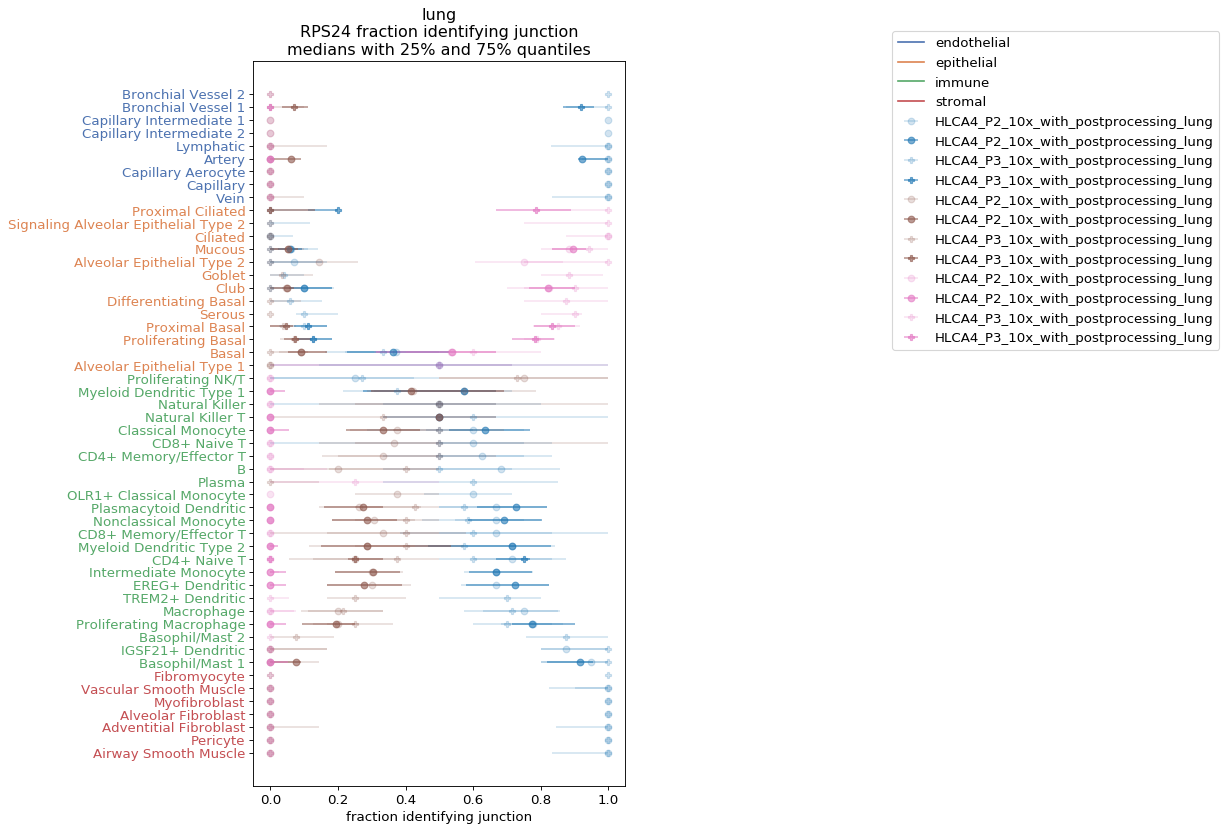

In [13]:
# merge_df = merge_df.sort_values(["m_inc_TS_10x_redo","m_inc_TSP2_10x_rerun_3prime_MYL6"])
merge_df["avg"] = merge_df[['chr10:RPS24:78037304:+|chr10:RPS24:78040204:+_med_frac_0.5_all_' + datanames[0],'chr10:RPS24:78037304:+|chr10:RPS24:78040204:+_med_frac_0.5_all_' + datanames[1]]].mean(axis=1)

# merge_df = merge_df.sort_values("avg")

merge_df = merge_df.sort_values(by=["compartment","avg"],ascending=False)

datanames = datanames[:2]
comp_dict = {"endothelial" : "blue", "epithelial" : "black", "stromal" : "green", "immune" : "red"}
compartments = sorted([x for x in list(df["compartment"].unique()) if x != None])

comp_dict = compartment_colors(compartments) 
matplotlib.rcParams.update({'font.size': 12})

for tiss, tiss_df in merge_df.groupby("tissue"):
  plt.figure(num=None, figsize=(6, 12), dpi=80, facecolor='w', edgecolor='k')
  comp_colors = [comp_dict[x] for x in tiss_df["compartment"]]
  x_vals = range(tiss_df.shape[0])
  colors = [u'#1f77b4', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
#   colors = [u'#9467bd', u'#2ca02c', u'#d62728', u'#ff7f0e', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
 
  fillstyles = ["full","full","full"]
  fill_dict = {x : y for x, y in zip(datanames,fillstyles)}
  markers = ["o","P","o"]
  marker_dict = {x : y for x, y in zip(datanames,markers)}
  # for i in range(len(juncs)):
  #   junc = juncs[i]
  for i in range(len(juncs)):
    junc = juncs[i]
    for dn in datanames:
      
  #   plt.errorbar(x_vals,merge_df["m_inc_" + dn],yerr=[merge_df["m_inc_" + dn] - merge_df["m_inc_0.25_" + dn],merge_df["m_inc_0.75_" + dn] - merge_df["m_inc_" + dn]],linestyle="",marker=marker_dict[dn],label=dn,alpha = 0.6,fillstyle=fill_dict[dn])
      plt.errorbar(tiss_df["{}_med_frac_0.5_all_{}".format(junc,dn)],x_vals,xerr=[tiss_df["{}_med_frac_0.5_all_{}".format(junc,dn)] - tiss_df["{}_med_frac_0.25_all_{}".format(junc,dn)],tiss_df["{}_med_frac_0.75_all_{}".format(junc,dn)] - tiss_df["{}_med_frac_0.5_all_{}".format(junc,dn)]],linestyle="",marker=marker_dict[dn],label=dn ,alpha = 0.2,fillstyle=fill_dict[dn],color=colors[i])
      plt.errorbar(tiss_df["{}_med_frac_0.5_hc_{}".format(junc,dn)],x_vals,xerr=[tiss_df["{}_med_frac_0.5_hc_{}".format(junc,dn)] - tiss_df["{}_med_frac_0.25_hc_{}".format(junc,dn)],tiss_df["{}_med_frac_0.75_hc_{}".format(junc,dn)] - tiss_df["{}_med_frac_0.5_hc_{}".format(junc,dn)]],linestyle="",marker=marker_dict[dn],label=dn ,alpha = 0.6,fillstyle=fill_dict[dn],color=colors[i])

  for comp, col in comp_dict.items():
    plt.plot([-1],[1],label=comp,color=col)
  #     plt.errorbar(x_vals,merge_df[junc + "_med_frac_0.5_" + dn].replace(0,np.nan),yerr=[merge_df[junc + "_med_frac_0.5_" + dn] - merge_df[junc + "_med_frac_0.25_" + dn],merge_df[junc + "_med_frac_0.75_" + dn] - merge_df[junc + "_med_frac_0.5_" + dn]],linestyle="",marker=marker_dict[dn],label=junc,alpha = 0.6,color=colors[i],fillstyle=fill_dict[dn])
  plt.legend(bbox_to_anchor=(1.7, 1.05))
  plt.yticks(x_vals,tiss_df["free_annotation"])#,rotation=90)
  plt.xlim([-0.05,1.05])
  count = 0
  for tick_label in plt.gca().get_yticklabels():
    tick_label.set_color(comp_colors[count])
    count += 1 

  plt.xlabel("fraction identifying junction")
  plt.title("{}\n{} fraction identifying junction\nmedians with 25% and 75% quantiles".format(tiss,gene))
  plt.savefig("{}/{}_scatter_{}.25.png".format(outpath,gene,tiss),bbox_inches="tight")
  plt.show()

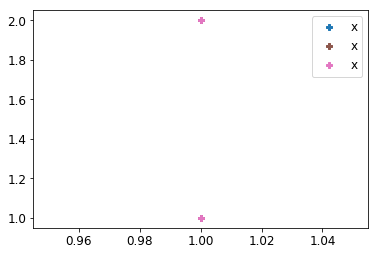

In [14]:
# cs = [u'#ff7f0e', u'#d62728', u'#9467bd']
for i in range(len(juncs)):
#   plt.plot([1,1],[1,2],color=cs[i],label=juncs[i],marker="o",linestyle="")
  plt.plot([1,1],[1,2],color=colors[i],label="x",marker="P",linestyle="")
plt.legend()
plt.show()